In [2]:
import config
from RiotAPI import *
from RiotRequest import RiotRequest
import requests

In [3]:
# timestamp handling functions
from datetime import timedelta
from datetime import datetime
import pytz

def convert_timedelta(milisecs):
    '''
    convert milisecond timestamp into python timedelta object
    for sake of compatiability, convert into only minutes and seconds (without hours)
    '''
    minDelta = timestamp // 60000 # 60000 miliseconds == 1 minute
    secDelta = (timestamp % 60000) // 1000 # 1000 miliseconds == 1 second
    return timedelta(minutes = minDelta, seconds = secDelta)

def convert_timestamp(timestamp):
    '''convert unix timestamp(long) into python datetime object with Korean Timezone'''
   
    # dealing with miliseconds part
    timestamp = timestamp/1000
    # convert from utc into datetime timestamp
    dt = datetime.utcfromtimestamp(timestamp).replace(tzinfo=pytz.utc)
    
    # convert into Korean timezone
    tz = pytz.timezone("Asia/Seoul")
    dt_kr = dt.astimezone(tz)
    
    return dt_kr

In [4]:
api_key = config.api_key
game_id = 3309773060
summoner_name = "야너어어어엌"
account_id = get_account_id(summoner_name)

## Match Time History

In [5]:
history = [match['gameId'] for match in get_match_history(account_id)]

In [6]:
len(history)

568

In [7]:
# get game detail에서 gameCreation이랑 gameDuration만 불러오기

# 이러면 get_game_detail을 두 번 호출함ㅜㅜ --> 너무 오래걸림
# history = [[matchId, get_game_detail(matchId)['gameCreation'], get_game_detail(matchId)['gameDuration']] for matchId in history]

def get_timeinfo(matchId):
    detail = get_game_detail(matchId)
    return [matchId, detail['gameCreation'], detail['gameDuration']]

# temporarily recent 300 games
time_history = [get_timeinfo(matchId) for matchId in history[:300]]


Exceeded Rate Limiting. Will retry After 79 seconds
Exceeded Rate Limiting. Will retry After 77 seconds
Exceeded Rate Limiting. Will retry After 79 seconds


In [8]:
import pandas as pd
match_df = pd.DataFrame(time_history, columns=['matchId', 'creation', 'duration'])

In [9]:
# add unix timestamp of the time game ended
match_df['ended'] = match_df['creation'] + match_df['duration']*1000

# add datetime columns for creation and ending time
match_df['creation_dt'] = match_df['creation'].apply(convert_timestamp)
match_df['ended_dt'] = match_df['ended'].apply(convert_timestamp)

match_df.head()

,matchId,creation,duration,ended,creation_dt,ended_dt
0,3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00
1,3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00
2,3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00
3,3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00
4,3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00


## Grouping Matches
__match_df: 개별 게임 기록을 하나의 row로 하는 dataframe__
- matchId(index)
- creation: __long__ 게임이 시작하는 unix timestamp
- duration: __int__ 게임 지속 시간 in seconds (*millisedconds가 아님에 유의*)
- ended: __long__ 게임이 끝나는 unix timestamp
- creation_dt: __datetime__ creation을 korean time으로 전환한 시각   
- ended_dt: __datetime__ ended를 korean time으로 전환한 시각  
- diff: __long__ 이번 판과 다음 판(시간 상으로 다음판, row 순서로는 바로 위 row)과의 시간 차이 in seconds

__seq_df: 연속 게임 기록을 하나의 row로 하는 dataframe__
- matchIds: list[matchId]
- matchNum: __int__ 연속으로 한 판 수
- start_dt: __datetime__ 연속 게임 기록의 시작시간
- end_dt: __datetime__ 연속 게임 기록의 끝나는 시간

In [11]:
import numpy as np
diff = np.array(match_df['creation'][:-1]) - np.array(match_df['ended'][1:])
len(diff)

299

In [12]:
import matplotlib
import matplotlib.pyplot as plt
plt = plt.hist(diff)

In [13]:
full_diff = np.append([float('Inf')], diff)
full_diff
match_df['diff'] = full_diff
match_df.head()

,matchId,creation,duration,ended,creation_dt,ended_dt,diff
0,3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00,inf
1,3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00,1.928550e+05
2,3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00,6.529660e+07
3,3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00,1.642027e+08
4,3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00,8.452036e+07


In [29]:
# match_df.set_index('matchId', inplace=True)
match_df.head()

,creation,duration,ended,creation_dt,ended_dt,diff
matchId,,,,,,
3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00,inf
3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00,1.928550e+05
3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00,6.529660e+07
3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00,1.642027e+08
3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00,8.452036e+07


In [33]:
# contruct sequence data
seqs = []

for index, row in match_df.iterrows():
    if row['diff'] > 600000: # diff with previous game bigger than 10 minutes
        seqs.append([index]) # start a new sequence(nested list) in seqs
    else: # diff with previous game smaller than 10 minutes
        seqs[-1].append(index) # add the match to an existing sequence

In [36]:
seq_df = pd.DataFrame()

# list of ids of matches
seq_df['matchIds'] = seqs
# how many matches in a row
seq_df['matchNum'] = [len(seq) for seq in seqs]
# start_dt
seq_df['start_dt'] = [match_df.loc[seq[-1]]['creation_dt'] for seq in seqs]
# end_dt
seq_df['end_dt'] = [match_df.loc[seq[0]]['ended_dt'] for seq in seqs]

seq_df.head()

,matchIds,matchNum,start_dt,end_dt
0,"[3663346965, 3663315079]",2,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:54:55.348000+09:00
1,[3662344066],1,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00
2,[3659959097],1,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00
3,"[3658808527, 3658851282, 3658735829, 3658669989]",4,2019-05-12 19:00:04.238000+09:00,2019-05-12 21:01:33.816000+09:00
4,[3655968230],1,2019-05-11 11:06:56.795000+09:00,2019-05-11 11:41:00.795000+09:00


## Insights on Play Time

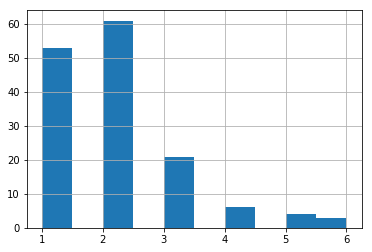

In [52]:
# 한 번 켰을 때 몇 판이나 연속으로 하는지
hist = seq_df['matchNum'].hist()

In [ ]:
# 접속 시간대 분포
# 접속 시간대 게임 판 수 가중 후 분포
# 간단히 한 판 하는 시간대 vs 여러 판 하는 시간대

In [ ]:
`